In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
gene_type_pal_greyed = {
    'new_lncRNA': '#b70657',         
    'existing_lncRNA': '#d6a5b7',    
    'sRNA': '#b3c6c6',           # lighter/greyer teal
    'pseudogene': '#c2b0c6',     # lighter/greyer purple
    'protein_coding': '#a3b9c6', # lighter/greyer blue
    'artifact': '#cccccc'}        # light grey


gene_type_pal= {'lncRNA':'#b70657',
                            'sRNA':'#2D716F',
                            'pseudogene':'#734675',
                            'protein_coding':'#016895', 
                            'artifact':'grey'}


In [20]:
gene_counts = pd.read_csv("/home/klawren/oak/gtex/data/other_references/gencode/gencode_transcript_counts.txt", sep=',')
gene_counts.head()

,gtex_year,gencode_year,gtex_version,gencode_version,total_genes,protein_coding,lncRNA,sRNA,pseudogene
0,2025,2024,v11,v47,78724,19844,35934,7565,14940
1,2024,2021,v10,v39,61533,20391,18811,7567,14999
2,2020,2016,v8,v26,58219,20227,15787,7568,14870
3,2018,2013,v7,v19,57820,20731,13870,9013,14436
4,2015,2013,v6,v19,57820,20731,13870,9013,14436


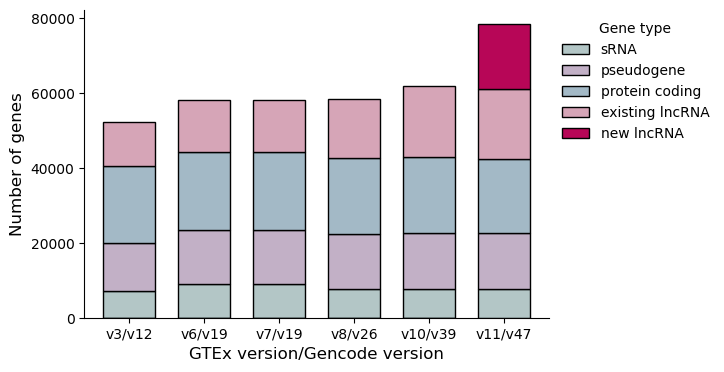

In [21]:
# Prepare data for stacked bar plot using custom color palette and correct order
gene_types = ['sRNA', 'pseudogene', 'protein_coding', 'lncRNA']
plot_data = gene_counts[['gtex_version'] + gene_types].copy()
plot_data = plot_data.set_index('gtex_version')

# Calculate new lncRNA for the last (most recent) GTEx version
lncrna_v47 = plot_data.loc['v11', 'lncRNA']
lncrna_v39 = plot_data.loc['v10', 'lncRNA']
new_lncrna = lncrna_v47 - lncrna_v39

# Add 'existing_lncRNA' and 'new_lncRNA' columns
plot_data['existing_lncRNA'] = plot_data['lncRNA']
plot_data['new_lncRNA'] = 0
plot_data.loc['v11', 'existing_lncRNA'] = lncrna_v39
plot_data.loc['v11', 'new_lncRNA'] = new_lncrna

# For plotting, use: sRNA, pseudogene, protein_coding, existing_lncRNA, new_lncRNA
plot_types = ['sRNA', 'pseudogene', 'protein_coding', 'existing_lncRNA', 'new_lncRNA']
plot_colors = [
    gene_type_pal_greyed['sRNA'],
    gene_type_pal_greyed['pseudogene'],
    gene_type_pal_greyed['protein_coding'],
    gene_type_pal_greyed['existing_lncRNA'],
    gene_type_pal_greyed['new_lncRNA']
]

# Reverse the order of the x-axis (GTEx versions)
reversed_plot_data = plot_data.loc[::-1]

plt.figure(figsize=(6, 4))
# Draw stacked bars with black edgecolor
ax = reversed_plot_data[plot_types].plot(
    kind='bar',
    stacked=True,
    color=plot_colors,
    ax=plt.gca(),
    edgecolor='black',
    width=0.7
)
plt.xlabel("GTEx version/Gencode version", fontsize=12)
plt.ylabel("Number of genes", fontsize=12)
plt.legend(
    ['sRNA', 'pseudogene', 'protein coding', 'existing lncRNA', 'new lncRNA'],
    title="Gene type"
)
# Set x-tick labels to "gtex version (gencode version)" format
gtex_versions = reversed_plot_data.index
gencode_versions = gene_counts.set_index('gtex_version').loc[gtex_versions, 'gencode_version']
xtick_labels = [f"{g}/{c}" for g, c in zip(gtex_versions, gencode_versions)]
ax.set_xticklabels(xtick_labels, rotation=0)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False)
ax.set_yticks(ax.get_yticks()[::2])
sns.despine()
plt.show()


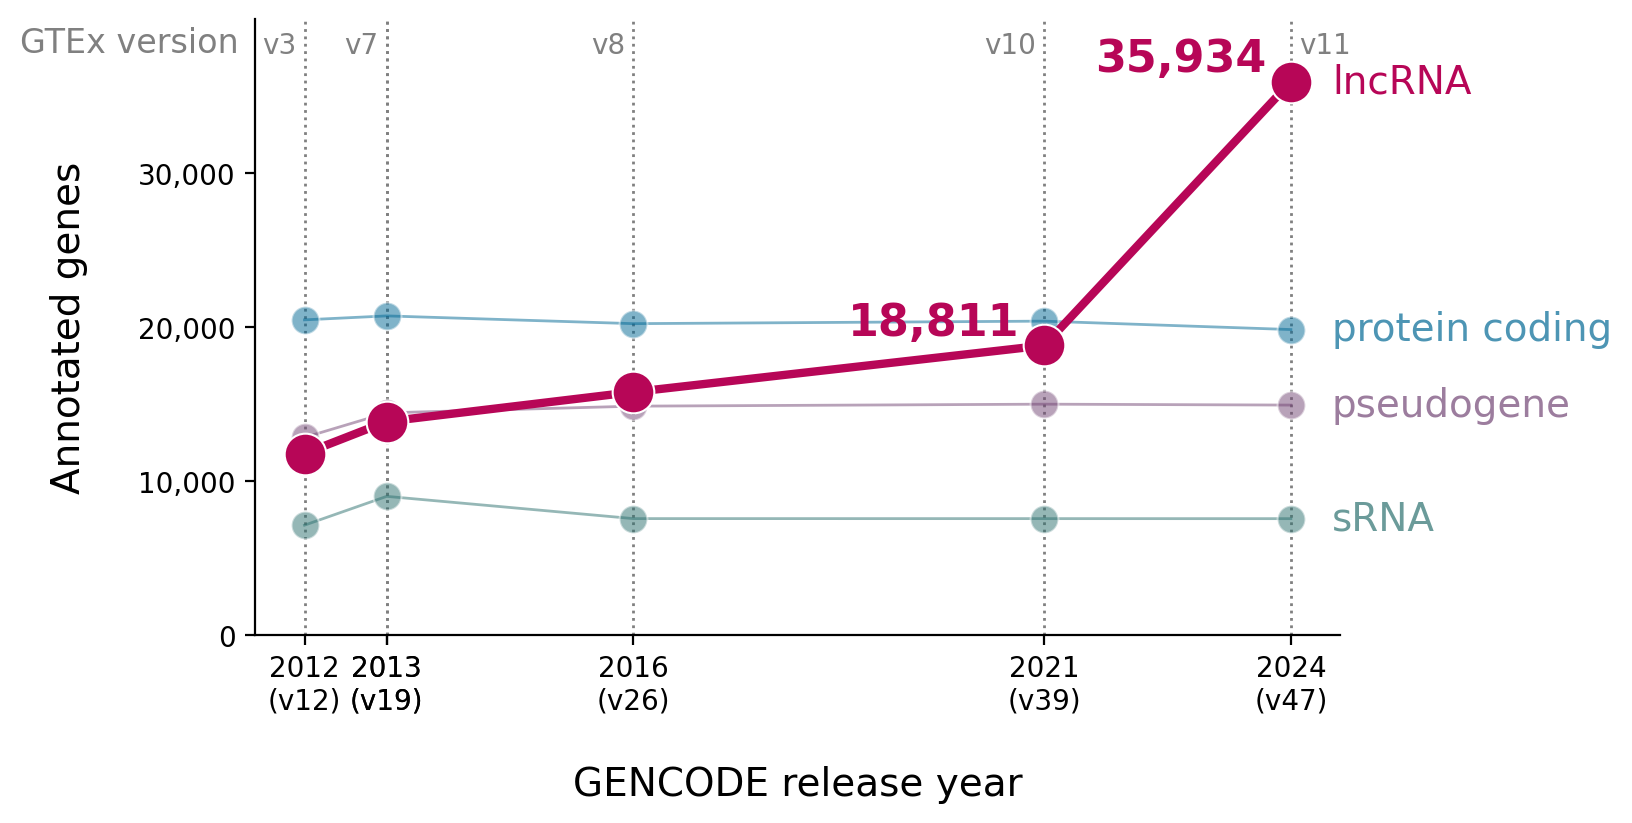

In [43]:
# Prepare data for line plot using custom color palette and correct order
gene_types = ['sRNA', 'pseudogene', 'protein_coding', 'lncRNA']
plot_data = gene_counts[['gencode_year', 'gencode_version', 'gtex_version'] + gene_types].copy()
plot_data = plot_data.set_index('gencode_year')

# For plotting, use: sRNA, pseudogene, protein_coding, lncRNA
plot_types = ['sRNA', 'pseudogene', 'protein_coding', 'lncRNA']

# Reverse the order of the x-axis (years, so descending)
reversed_plot_data = plot_data.loc[::-1]

plt.figure(figsize=(7, 4), dpi=200)
ax = plt.gca()
line_handles = {}
# Plot a line for each gene type in reversed_plot_data
for gene_type in plot_types:
    line = sns.lineplot(
        x=reversed_plot_data.index,
        y=reversed_plot_data[gene_type],
        marker='o',
        markersize=15 if gene_type == 'lncRNA' else 10,
        label=gene_type.replace('_', ' ').capitalize(),
        color=gene_type_pal.get(gene_type, None),
        ax=ax, 
        alpha=1 if gene_type == 'lncRNA' else 0.5,
        lw=3 if gene_type == 'lncRNA' else 1
    )
    # Store the last x, y for labeling
    last_x = reversed_plot_data.index[-1]
    last_y = reversed_plot_data[gene_type].iloc[-1]
    line_handles[gene_type] = (last_x, last_y)

# Add more padding to the axis labels using labelpad
plt.xlabel("GENCODE release year", fontsize=14, labelpad=18)
plt.ylabel("Annotated genes", fontsize=14, labelpad=18)

# Remove the legend, since we will label lines directly
if ax.legend_:
    ax.legend_.remove()

# Set x-tick labels to "release year (vx)" format
gencode_versions = reversed_plot_data['gencode_version']
xtick_labels = [f"{year}\n({ver})" for year, ver in zip(reversed_plot_data.index, gencode_versions)]
ax.set_xticks(reversed_plot_data.index)
ax.set_xticklabels(xtick_labels, rotation=0)

# Add dotted vertical lines for each GTEx version, with labels at the top right
gtex_versions = reversed_plot_data['gtex_version']
ymax = ax.get_ylim()[1]
for i, (x, gtex_ver) in enumerate(zip(reversed_plot_data.index, gtex_versions)):
    # Draw a dotted line for every GTEx version, including v11
    ax.axvline(x=x, color='grey', linestyle='dotted', linewidth=1, zorder=0)
    # Only label to the right of the plot, and skip label for v6
    if gtex_ver != 'v6':
        # For v11, place the label to the right of the line
        if gtex_ver == 'v11':
            ax.text(
                x=x + 0.1,
                y=ymax * 1,
                s=gtex_ver,
                color='grey',
                ha='left',
                va='bottom',
                fontsize=10,
                rotation=0,
            )
        else:
            ax.text(
                x=x - 0.1,
                y=ymax * 1,
                s=gtex_ver,
                color='grey',
                ha='right',
                va='bottom',
                fontsize=10,
                rotation=0,
            )

# Add labels to the right of each line in the color of the line
for gene_type in plot_types:
    last_x, last_y = line_handles[gene_type]
    color = gene_type_pal.get(gene_type, None)
    label = gene_type.replace('_', ' ')
    # Place label slightly to the right of the last x-tick
    ax.text(
        x=last_x + 0.5,  # Offset to the right
        y=last_y,
        s=label,
        color=color,
        va='center',
        fontsize=14,
        alpha=1 if gene_type == 'lncRNA' else 0.7
    )

# Label the last two lncRNA points with their values
lncrna_xs = reversed_plot_data.index[-2:]
lncrna_ys = reversed_plot_data['lncRNA'].iloc[-2:]
for x, y in zip(lncrna_xs, lncrna_ys):
    ax.text(
        x=x-.3,
        y=y+1500,
        s=f"{int(y):,}",
        color=gene_type_pal['lncRNA'],
        va='center',
        ha='right',
        fontsize=16,
        fontweight='bold',
        alpha=1
    )

ax.set_ylim(0, ax.get_ylim()[1])

# Set y-ticks, and add "gtex version" as grey text (not a tick)
yticks = ax.get_yticks()[::2][:-1]
if len(yticks) > 1:
    ax.set_yticks(yticks)
    yticklabels = [f"{int(y):,}" for y in yticks]
    ax.set_yticklabels(yticklabels)
    # Add "gtex version" as grey text to the right of the y-axis, aligned with 38500
    ax.text(
        x=ax.get_xlim()[0] - 0.2,
        y=38500,
        s="GTEx version",
        color='grey',
        va='center',
        ha='right',
        fontsize=12
    )
else:
    ax.set_yticks(yticks)

ax.set_ylim(0, 40000)

sns.despine()
plt.show()

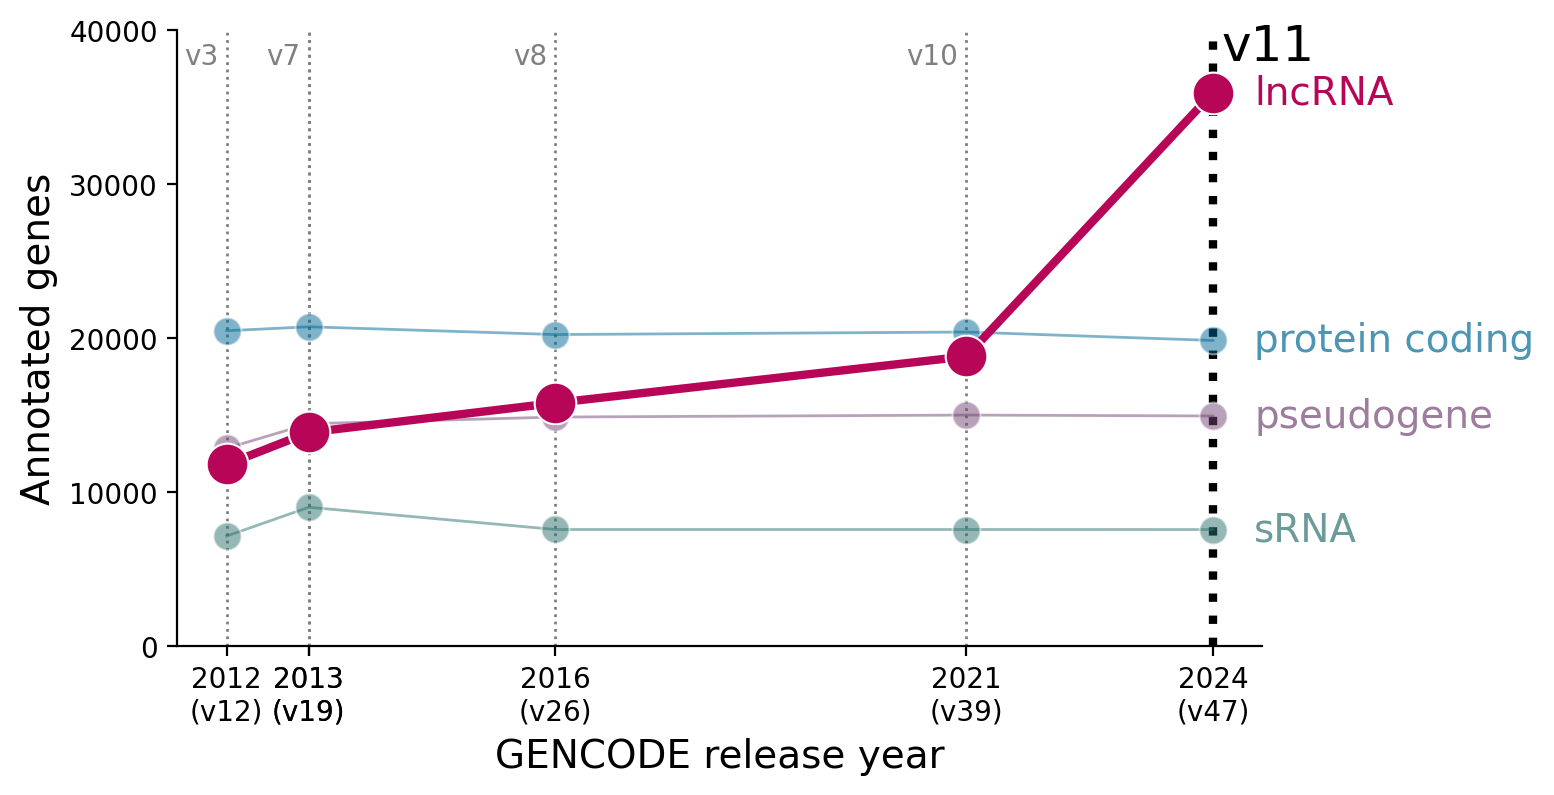

In [15]:
# Prepare data for line plot using custom color palette and correct order
gene_types = ['sRNA', 'pseudogene', 'protein_coding', 'lncRNA']
plot_data = gene_counts[['gencode_year', 'gencode_version', 'gtex_version'] + gene_types].copy()
plot_data = plot_data.set_index('gencode_year')

plot_types = ['sRNA', 'pseudogene', 'protein_coding', 'lncRNA']

# Reverse the order of the x-axis (years, so descending)
reversed_plot_data = plot_data.loc[::-1]

plt.figure(figsize=(7, 4), dpi=200)
ax = plt.gca()
line_handles = {}

# Plot a line for each gene type in reversed_plot_data
for gene_type in plot_types:
    line = sns.lineplot(
        x=reversed_plot_data.index,
        y=reversed_plot_data[gene_type],
        marker='o',
        markersize=15 if gene_type == 'lncRNA' else 10,
        label=gene_type.replace('_', ' ').capitalize(),
        color=gene_type_pal.get(gene_type, None),
        ax=ax,
        alpha=1 if gene_type == 'lncRNA' else 0.5,
        lw=3 if gene_type == 'lncRNA' else 1
    )
    last_x = reversed_plot_data.index[-1]
    last_y = reversed_plot_data[gene_type].iloc[-1]
    line_handles[gene_type] = (last_x, last_y)

plt.xlabel("GENCODE release year", fontsize=14)
plt.ylabel("Annotated genes", fontsize=14)

# Remove the legend, since we will label lines directly
if ax.legend_:
    ax.legend_.remove()

# Set x-tick labels to "release year (vx)" format
gencode_versions = reversed_plot_data['gencode_version']
xtick_labels = [f"{year}\n({ver})" for year, ver in zip(reversed_plot_data.index, gencode_versions)]
ax.set_xticks(reversed_plot_data.index)
ax.set_xticklabels(xtick_labels, rotation=0)

# Add dotted vertical lines for each GTEx version, with v11 line darker/thicker and label larger
gtex_versions = reversed_plot_data['gtex_version']
ymax = ax.get_ylim()[1]
for i, (x, gtex_ver) in enumerate(zip(reversed_plot_data.index, gtex_versions)):
    if gtex_ver == 'v11':
        ax.axvline(x=x, color='black', linestyle='dotted', linewidth=3, zorder=1)
        ax.text(
            x=x + 0.1,
            y=ymax * 1,
            s=gtex_ver,
            color='black',
            ha='left',
            va='bottom',
            fontsize=18,
            rotation=0,
            zorder=10
        )
    elif gtex_ver != 'v6':
        ax.axvline(x=x, color='grey', linestyle='dotted', linewidth=1, zorder=0)
        ax.text(
            x=x - 0.1,
            y=ymax * 1,
            s=gtex_ver,
            color='grey',
            ha='right',
            va='bottom',
            fontsize=10,
            rotation=0,
            zorder=10
        )
    else:
        ax.axvline(x=x, color='grey', linestyle='dotted', linewidth=1, zorder=0)

# Add labels to the right of each line in the color of the line
for gene_type in plot_types:
    last_x, last_y = line_handles[gene_type]
    color = gene_type_pal.get(gene_type, None)
    label = gene_type.replace('_', ' ')
    ax.text(
        x=last_x + 0.5,
        y=last_y,
        s=label,
        color=color,
        va='center',
        fontsize=14,
        alpha=1 if gene_type == 'lncRNA' else 0.7
     )

# # Label the last two lncRNA points with their values
# lncrna_xs = reversed_plot_data.index[-2:]
# lncrna_ys = reversed_plot_data['lncRNA'].iloc[-2:]
# for x, y in zip(lncrna_xs, lncrna_ys):
#     ax.text(
#         x=x-.3,
#         y=y+1500,
#         s=f"{int(y):,}",
#         color=gene_type_pal['lncRNA'],
#         va='center',
#         ha='right',
#         fontsize=16,
#         fontweight='bold',
#         alpha=1
#     )

ax.set_ylim(0, ax.get_ylim()[1])
ax.set_yticks(ax.get_yticks()[::2])

sns.despine()
plt.show()

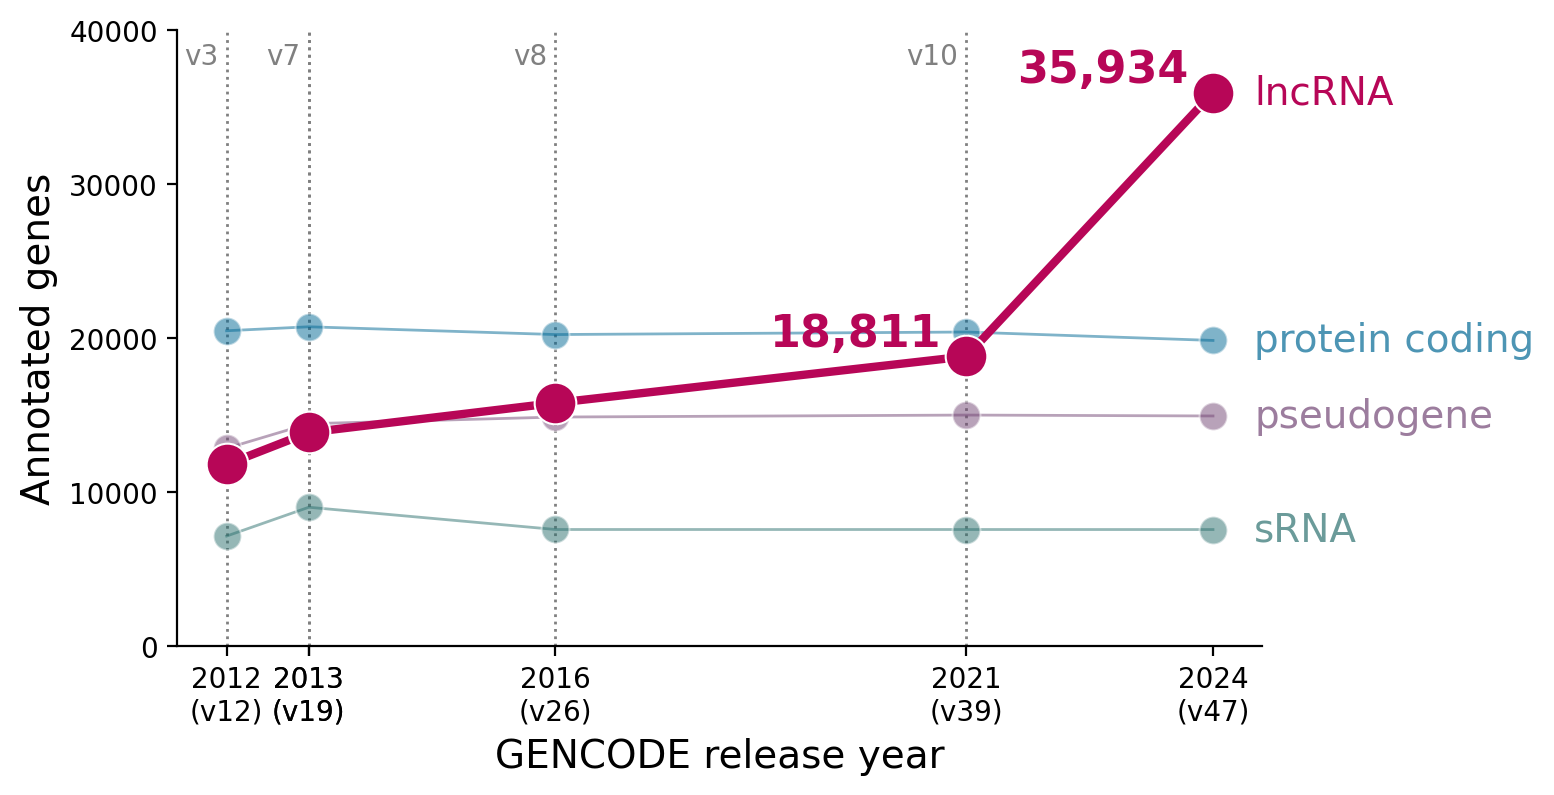